In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Image: /home/nan/sneaker_ai/screened_data/air_jordan_5/air_jordan_5_34.jpg
Label: AJ +  5


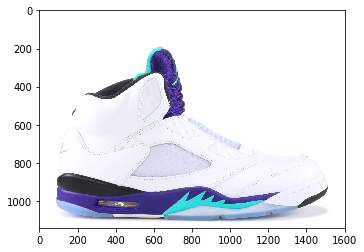

In [2]:
import random

all_df = pd.read_csv('dataset_df.csv')
n = random.randint(0, len(all_df)-1)
image_file = all_df.iloc[n,1]
label = all_df.iloc[n,2]
print("Image:", image_file)
print("Label: AJ + ", str(label+1))
plt.imshow(io.imread(image_file))

In [3]:
class AJDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, n):
        img_name = self.df.iloc[n,1]
        image = io.imread(img_name)
        label = self.df.iloc[n,2]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [4]:
n_classes = 5
classes = ["AJ "+ str(i) for i in range(1,6)]
batch_size = 16
# transform = transforms.Compose(
#                     [transforms.ToPILImage(),
#                     transforms.Grayscale(),
#                     transforms.Resize(size=(224,224)),
#                     transforms.ToTensor(),
#                     ])

## add random transforms for data augmentation
transform = transforms.Compose(
                    [transforms.ToPILImage(),
                    transforms.Grayscale(),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.Resize(size=(256,256)),
                    transforms.RandomCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    ])

train_dataset = AJDataset('train_df.csv', transform = 
transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,shuffle = True)

test_dataset = AJDataset('test_df.csv', transform = 
transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                batch_size=batch_size,shuffle = True)


tensor(0.)
tensor(1.)
AJ 1


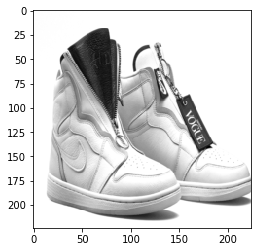

In [ ]:
imgs, lbls = next(iter(train_loader))
imgs[0].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(classes[lbls[0]])
plt.imshow(imgs[0].data.reshape((224,224)), cmap="gray")

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.conv1 = nn.Sequential(
#                         nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2, stride=2))
#         self.conv2 = nn.Sequential(
#                         nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2, stride=2))
#         self.conv3 = nn.Sequential(
#                         nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2, stride=2))
#         self.conv4 = nn.Sequential(
#                         nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2, stride=2))
#         self.conv5 = nn.Sequential(
#                         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
#                         nn.ReLU(inplace=True),
#                         nn.MaxPool2d(kernel_size=2, stride=2))
#         self.fc = nn.Sequential(
#                         nn.Dropout(p=0.5),
#                         nn.Linear(in_features=7*7*32, out_features=256),
#                         nn.ReLU(inplace=True),
#                         nn.Dropout(p=0.5),
#                         nn.Linear(in_features=256, out_features=64),
#                         nn.ReLU(inplace=True),
#                         nn.Dropout(p=0.5),
#                         nn.Linear(in_features=64, out_features=5))
# #         self.dropout = nn.Dropout(p=0.5)
    
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)
#         x = x.view((x.shape[0],-1))
#         x = self.fc(x)
#         x = F.log_softmax(x, dim=1)
#         return x

In [ ]:
## smaller model to reduce overfitting
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=4, stride=4))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=4, stride=4))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=7*7*32, out_features=128),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=128, out_features=16),
                        nn.ReLU(inplace=True),
                        nn.Dropout(p=0.5),
                        nn.Linear(in_features=16, out_features=5))
#         self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view((x.shape[0],-1))
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
model = Model()
model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Epoch: 32/200..  Training Loss: 1.417..  Training Accuracy: 0.407..  Test Loss: 1.386..  Test Accuracy: 0.441
Epoch 32 / 200 took  37.38 seconds
Total training time till this epoch was  1090.75 seconds


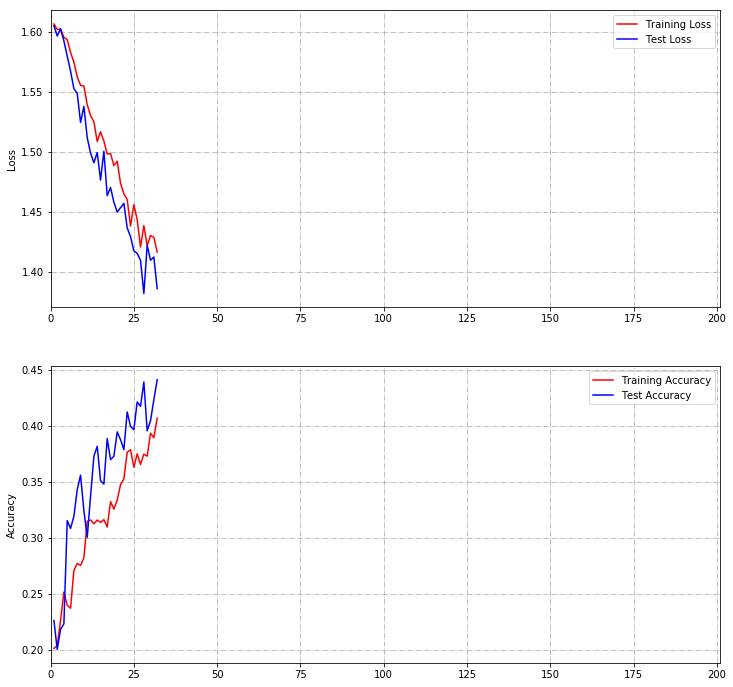

In [ ]:
import time
from IPython.display import clear_output

epochs = 200
train_losses, test_losses = [], []
train_accu, test_accu = [], []
start_time = time.time()
for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        train_losses.append(running_loss/len(train_loader))
        train_accu.append(accuracy/len(train_loader))
        
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        test_losses.append(test_loss/len(test_loader))
        test_accu.append(accuracy/len(test_loader))

        clear_output(wait=True)
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Training Accuracy: {:.3f}.. ".format(train_accu[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(test_accu[-1]))
    
        print('Epoch %d / %d took %6.2f seconds' % (e+1, epochs, time.time()-epoch_start_time))
        print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))

        plt.figure(figsize=(12,12))
        plt.subplot(2,1,1)
        ax = plt.gca()
        ax.set_xlim([0, epochs + 1])
        plt.ylabel('Loss')
        plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
        plt.plot(range(1, e + 2), test_losses[:e+1], 'b', label='Test Loss')
        ax.grid(linestyle='-.')
        plt.legend()
        plt.subplot(2,1,2)
        ax = plt.gca()
        ax.set_xlim([0, epochs + 1])
        plt.ylabel('Accuracy')
        plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
        plt.plot(range(1, e + 2), test_accu[:e+1], 'b', label='Test Accuracy')
        ax.grid(linestyle='-.')
        plt.legend()
        plt.show()
        if (e+1) % 10 == 0:
            torch.save(model.state_dict(), 'model--{}.ckpt'.format(e+1))

In [ ]:
train_loss = 0
accuracy = 0
with torch.no_grad():
    images,labels = next(iter(train_loader))
    images = images.to(device)
    labels = labels.to(device)
    log_ps = model(images)
    train_loss += criterion(log_ps, labels)
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

In [ ]:
plt.imshow(images[10].cpu().numpy().reshape((224,224)), cmap="gray")

In [ ]:
labels

In [ ]:
top_class.view((1, -1))